# Figure 2

In [2]:
## Basics
import numpy as np
import pandas as pd
import glob
import mdtraj as md

## Local functions
import sys
sys.path.append("../code/scripts")
import parseaf as paf
import composition as comp

## Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams.update({'font.size': 14})
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = "Arial"

## Colors
cscheme = {'pos':'#0177BB', 'neg':'#CB3627', 'dis':'#828282', 'helix':'#009988', 'sheet':'#EE7733', 'cr':'#AA4499',
          'null':"black"}

In [3]:
# Filepaths
path_to_af_data = "/Volumes/DATA/alphafold/UP000002311_559292_YEAST/"

### Local functions

In [4]:
def get_ss_freqs(seq, counts = False, sort_output = True, gaps = False):
    ss_types = ['C', 'E', 'H']
    
    all_seq_ss = []
    all_seq_freqs = []
    
    # Parse sequence
    seq = list(seq)
    seq_ss, seq_counts = np.unique(seq, return_counts=True)
    zero_freq_ss = np.setxor1d(ss_types, seq_ss)

    seq_ss = np.append(seq_ss, zero_freq_ss)
    seq_freqs = np.append(seq_counts, np.zeros(zero_freq_ss.size))
    if not counts:
        seq_freqs = seq_freqs / len(seq)

    if sort_output:
        seq_freqs_sorted = seq_freqs[seq_ss.argsort()]
        all_seq_freqs.append(seq_freqs_sorted)

    else:
        all_seq_ss.append(seq_ss)
        all_seq_freqs.append(seq_freqs)
    
    if sort_output:
        return(all_seq_freqs)
    else:
        return(all_seq_ss, all_seq_freqs)
    
    
def subcategorybar(X, vals, labs, width=0.8, colors=None):
    n = len(vals)
    _X = np.arange(len(X))
    if colors:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i], color=colors[i])
    else:
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], 
                    width=width/float(n), align="edge", label=labs[i])
    plt.xticks(_X, X)
    plt.legend()

## A

In [5]:
df = pd.read_csv('../data/charged_regions/cr_raw.csv',
                comment="#")

In [6]:
# Calculate normalized hydropathy, net charge, and percent disordered for each sequence
hits_disordered_frac = []
hits_conf = []
hits_ss = []

for index, row in df.iterrows():
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    # Read alphafold pLDDT scoress for the sequence
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']+1]
    except FileNotFoundError:
        print(af_fp)
        continue
    
    
    #disordered = np.sum([1 for i in pLDDTs if i < 70.])
    
    # Get confidence scores mask
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Secondary structure prediction for each region
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][row['left.bound']:row['right.bound']+1]
    hits_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 50.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
        
    # Calculate fraction disorder for the region
    hits_disordered_frac.append(disordered / row['region.len'])
    hits_conf.append(conf)
    
# Saving the above data because it is slow to run
# np.savetxt("../data/af_ss_processed/hits_disordered_frac.txt", hits_disordered_frac)
# np.save("../data/af_ss_processed/hits_conf.npy", hits_conf, allow_pickle=True)
# np.save("../data/af_ss_processed/hits_ss.npy", hits_ss, allow_pickle=True)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P53288-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P36022-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q6B0X1-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q08428-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12444-F1-model_v1.pdb.gz


In [20]:
# Compare to random regions of the same length
all_af_predictions = glob.glob(path_to_af_data+'*.pdb.gz')

rand_disordered_frac = []
rand_conf = []
rand_ss = []


for index, row in df.iterrows():
    # Choose random alphafold output
    rfile = np.random.choice(all_af_predictions)
    raf = paf.read_bfactor_from_pdb(rfile)
    # If the length of the protein is less than the region, redraw
    while row['region.len'] > len(raf):
        rfile = np.random.choice(all_af_predictions)
        raf = paf.read_bfactor_from_pdb(rfile)
    
    rstart = np.random.choice(np.arange(len(raf) - row['region.len']+1))
    rend = rstart+row['region.len']+1
    
    # Get the sequence of this random region
    rseq = paf.read_seq_from_pdb(rfile)[rstart:rend]
    if len(rseq) == 0:
        continue
    rpLDDTs = raf[rstart:rend]
    
    
    # Score each residue as disordered or ordered based on pLDDT value
    #disordered = np.sum([1 for i in rpLDDTs if i < 70.])
    conf = [True if i > 70. else False for i in rpLDDTs]
    

    
    # Secondary structure prediction for each region
    structure = md.load(rfile)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][rstart:rend]
    rand_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(rpLDDTs):
        if resid < 50.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
            
    # Calculate fraction disorder for the region
    rand_disordered_frac.append(disordered / row['region.len'])
    rand_conf.append(conf)

# Saving the above data because it is slow to run
# np.savetxt("../data/af_ss_processed/rand_disordered_frac.txt", rand_disordered_frac)
# np.save("../data/af_ss_processed/rand_conf.npy", rand_conf, allow_pickle=True)
# np.save("../data/af_ss_processed/rand_ss.npy", rand_ss, allow_pickle=True)

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


In [8]:
# Compare to regions from disprot:
yeast_disprot = pd.read_csv("../data/misc/search_in_disprot.tsv", sep = "\t")
uniprot_to_sgid = pd.read_table("../data/misc/uniprot-acc_to_sgid.txt", sep = "\t")
sgid_to_orf_names = ["SGID", "orf", "gene", "gene_name", "sgd_alias", "brief_description", "organism", "gene_type"]
sgid_to_orf = pd.read_csv("../data/misc/all-sgd-orfs-w-sgid-and-systematic.tsv", sep = "\t", names=sgid_to_orf_names)

In [9]:
mapping = pd.merge(uniprot_to_sgid, sgid_to_orf, how="left", on="SGID")
mapping = mapping.drop(["gene_name", "sgd_alias", "brief_description", "organism", "gene_type"], axis=1)
yeast_disprot_w_orfs = pd.merge(yeast_disprot, mapping, how='left', on=["acc"])
#yeast_disprot_w_orfs.head()

In [10]:
idr_disordered_frac = []
idr_conf = []
idr_ss = []


for index, row in yeast_disprot_w_orfs.iterrows():
    orf = row['orf']
    uid = row['acc']
    seq = row['region_sequence']
    start = row['start']
    end = row['end']

    # Pull the alphafold prediction for this region
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[start:end]
    except FileNotFoundError:
        print("File {} not found".format(af_fp))
        continue
        
    # Check that region matches af prediction
    af_seq = paf.read_seq_from_pdb(af_fp)[start-1:end]
    if af_seq != seq:
        print("Sequences don't match for Uniprot ID {} (orf {})".format(uid,orf))
        continue

    # Binarize confidence scores
    conf = [True if i > 70. else False for i in pLDDTs]
    
    # Secondary structure prediction for each region
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)
    region_ss = ss[0][start:end]
    idr_ss.append(region_ss)
    
    # Score each residue as disordered or ordered based on pLDDT value
    ### UPDATE
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 50.:
            disordered += 1
        elif region_ss[r] == 'C':
            disordered += 1
    
    # Calculate fraction disorder for the region
    idr_disordered_frac.append(disordered / len(seq))
    idr_conf.append(conf)

# Saving the above data because it is slow to run
# np.savetxt("../data/af_ss_processed/idr_disordered_frac.txt", idr_disordered_frac)
# np.save("../data/af_ss_processed/idr_conf.npy", idr_conf, allow_pickle=True)
# np.save("../data/af_ss_processed/idr_ss.npy", idr_ss, allow_pickle=True)

In [18]:
# Load data
hits_disordered_frac = np.loadtxt("../data/af_ss_processed/hits_disordered_frac.txt")
rand_disordered_frac = np.loadtxt("../data/af_ss_processed/rand_disordered_frac.txt")
idr_disordered_frac = np.loadtxt("../data/af_ss_processed/idr_disordered_frac.txt")

hits_conf = np.load("../data/af_ss_processed/hits_conf.npy", allow_pickle=True)
rand_conf = np.load("../data/af_ss_processed/rand_conf.npy", allow_pickle=True)
idr_conf = np.load("../data/af_ss_processed/idr_conf.npy", allow_pickle=True)

hits_ss = np.load("../data/af_ss_processed/hits_ss.npy", allow_pickle=True)
rand_ss = np.load("../data/af_ss_processed/rand_ss.npy", allow_pickle=True)
idr_ss = np.load("../data/af_ss_processed/idr_ss.npy", allow_pickle=True)

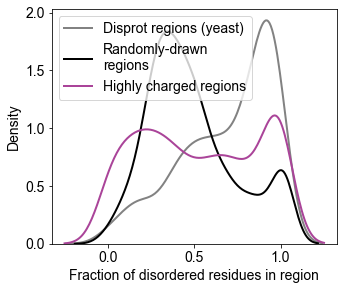

In [19]:
plt.figure(figsize=(5,4.25))
sns.kdeplot(idr_disordered_frac, label='Disprot regions (yeast)', color=cscheme['dis'], linewidth=2)
sns.kdeplot(rand_disordered_frac, label='Randomly-drawn\nregions', color=cscheme['null'], linewidth=2)
sns.kdeplot(hits_disordered_frac, label='Highly charged regions', color=cscheme['cr'], linewidth=2)
plt.xlabel('Fraction of disordered residues in region')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()

## B

In [8]:
data_dict = {"DisProt\nregions":None, "Random\nregions":None, "Hits":None}
labs = ["DisProt\nregions", "Random\nregions", "Hits"]
datums = [idr_ss, rand_ss, hits_ss]
confs = [idr_conf, rand_conf, hits_conf]

for i in range(3):
    out = {"Helix":0, "Sheet":0, "Disordered":0}
    for s, seq in enumerate(datums[i]):
        for aa in seq[confs[i][s]]:
            if aa == "C":
                out["Disordered"]+=1
            elif aa == "H":
                out["Helix"]+=1
            elif aa == "E":
                out["Sheet"]+=1
            else:
                pass
        diso = len(confs[i][s]) - len(seq[confs[i][s]])
        assert diso >= 0
        out["Disordered"] += diso
    data_dict[labs[i]] = out


allssdf = pd.DataFrame(data_dict)
allssdf.reset_index(inplace=True)
allssdf.rename(columns={'index':"ss_type"}, inplace=True)
allssdf = allssdf.melt(id_vars='ss_type', var_name="prot_type", value_name='n_aas')

In [9]:
allssdf = pd.DataFrame(data_dict)
allssdf.reset_index(inplace=True)
allssdf.rename(columns={'index':"ss_type"}, inplace=True)
allssdf = allssdf.melt(id_vars='ss_type', var_name="prot_type", value_name='n_aas')

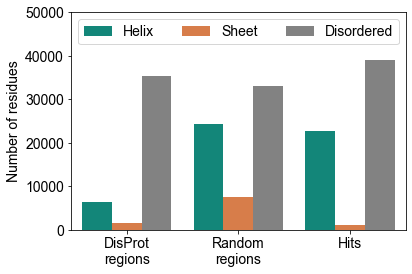

In [10]:
sns.barplot(x="prot_type", y="n_aas", hue='ss_type', data=allssdf, palette=[cscheme['helix'], cscheme['sheet'], cscheme['dis']])
plt.xlabel(None)
plt.ylabel("Number of residues")
plt.legend(title=None, ncol=3)
plt.ylim(0,50000)
plt.show()

## C

In [11]:
import chargepatterns as cp

In [12]:
sv_keys = ['sv' + str(x) for x in np.arange(1, 31)]
sv_seqs = ["EKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEKEK",
"EEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEEEKKKEK",
"KEKKKEKKEEKKEEKEKEKEKEEKKKEEKEKEKEKKKEEKEKEEKKEEEE",
"KEKEKKEEKEKKEEEKKEKEKEKKKEEKKKEEKEEKKEEKKKEEKEEEKE",
"KEKEEKEKKKEEEEKEKKKKEEKEKEKEKEEKKEEKKKKEEKEEKEKEKE",
"EEEKKEKKEEKEEKKEKKEKEEEKKKEKEEKKEEEKKKEKEEEEKKKKEK",
"EEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEK",
"KKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKKKKEEEEKE",
"EEKKEEEKEKEKEEEEEKKEKKEKKEKKKEEKEKEKKKEKKKKEKEEEKE",
"EKKKKKKEEKKKEEEEEKKKEEEKKKEKKEEKEKEEKEKKEKKEEKEEEE",
"EKEKKKKKEEEKKEKEEEEKEEEEKKKKKEKEEEKEEKKEEKEKKKEEKK",
"EKKEEEEEEKEKKEEEEKEKEKKEKEEKEKKEKKKEKKEEEKEKKKKEKK",
"KEKKKEKEKKEKKKEEEKKKEEEKEKKKEEKKEKKEKKEEEEEEEKEEKE",
"EKKEKEEKEEEEKKKKKEEKEKKEKKKKEKKKKKEEEEEEKEEKEKEKEE",
"KKEKKEKKKEKKEKKEEEKEKEKKEKKKKEKEKKEEEEEEEEKEEKKEEE",
"EKEKEEKKKEEKKKKEKKEKEEKKEKEKEKKEEEEEEEEEKEKKEKKKKE",
"EKEKKKKKKEKEKKKKEKEKKEKKEKEEEKEEKEKEKKEEKKEEEEEEEE",
"KEEKKEEEEEEEKEEKKKKKEKKKEKKEEEKKKEEKKKEEEEEEKKKKEK",
"EEEEEKKKKKEEEEEKKKKKEEEEEKKKKKEEEEEKKKKKEEEEEKKKKK",
"EEKEEEEEEKEEEKEEKKEEEKEKKEKKEKEEKKEKKKKKKKKKKKKEEE",
"EEEEEEEEEKEKKKKKEKEEKKKKKKEKKEKKKKEKKEEEEEEKEEEKKK",
"KEEEEKEEKEEKKKKEKEEKEKKKKKKKKKKKKEKKEEEEEEEEKEKEEE",
"EEEEEKEEEEEEEEEEEKEEKEKKKKKKEKKKKKKKEKEKKKKEKKEEKK",
"EEEEKEEEEEKEEEEEEEEEEEEKKKEEKKKKKEKKKKKKKEKKKKKKKK",
"EEEEEEEEEEEKEEEEKEEKEEKEKKKKKKKKKKKKKKKKKKEEKKEEKE",
"KEEEEEEEKEEKEEEEEEEEEKEEEEKEEKKKKKKKKKKKKKKKKKKKKE",
"KKEKKKEKKEEEEEEEEEEEEEEEEEEEEKEEKKKKKKKKKKKKKKKEKK",
"EKKKKKKKKKKKKKKKKKKKKKEEEEEEEEEEEEEEEEEEKKEEEEEKEK",
"KEEEEKEEEEEEEEEEEEEEEEEEEEEKKKKKKKKKKKKKKKKKKKKKKK",
"EEEEEEEEEEEEEEEEEEEEEEEEEKKKKKKKKKKKKKKKKKKKKKKKKK"]
svs = dict(zip(sv_keys, sv_seqs))

In [13]:
sv_kappas = [cp.kappa(x) for x in sv_seqs]
sv_helix_data = np.genfromtxt("../data/agadir/2021-02-04_sv-series_pH-7.txt", skip_header=11)[:, 1::2]
sv_helix_probs = sv_helix_data[:,-1]

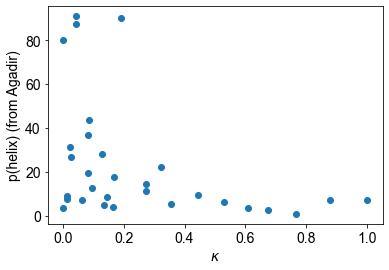

In [14]:
plt.figure(figsize=(6, 4))
plt.scatter(sv_kappas, sv_helix_probs)
plt.xlabel("$\kappa$")
plt.ylabel("p(helix) (from Agadir)")
plt.show()

In [116]:
tops_df = pd.read_csv("../data/top-structured-and-unstructured/2021-11-04_highly-structured_scored.csv")
tops_df = tops_df[tops_df["gene"] != "NPA3"] # I mislabeled this protein because the indexes in PDB were different than SGD

In [117]:
prot_counts = tops_df[["orf","structure.in.pdb"]]
prot_counts.drop_duplicates(inplace=True)
prot_counts = prot_counts['structure.in.pdb'].value_counts()
prot_freqs = prot_counts/np.sum(prot_counts)

<ipython-input-117-860ed8149d70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prot_counts.drop_duplicates(inplace=True)


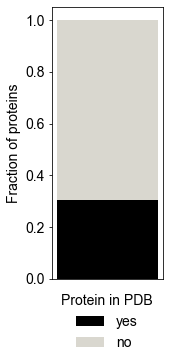

In [118]:
plt.figure(figsize=(2,5))
plt.bar(" ",prot_freqs["y"], label = "yes", color=cscheme['null'])
plt.bar(" ",prot_freqs["n"], bottom=prot_freqs["y"], label = "no", color="#D9D7CF")
plt.legend(bbox_to_anchor=(1.02, -0.01), title="Protein in PDB", frameon=False)
plt.ylabel("Fraction of proteins")
plt.tick_params(bottom=False)
plt.show()

In [119]:
y_prots = tops_df[["orf", "left.bound", "structure.in.pdb", "region.in.pdb", "helix"]]
y_prots = y_prots[y_prots["structure.in.pdb"] == 'y']

In [120]:
def make_region_label(row):
    if row["region.in.pdb"] == "n":
        return("Region absent")
    else:
        if row["helix"] == "y":
            return("Resolved helix")
        elif row["helix"] == "partial":
            return("Resolved helix")
        else:
            return("Resolved other")

y_prots["label"] = y_prots.apply(make_region_label, axis=1)
region_label_counts = y_prots["label"].value_counts()
region_label_freqs = region_label_counts / np.sum(region_label_counts)

In [121]:
region_label_freqs

Resolved helix    0.645161
Region absent     0.306452
Resolved other    0.048387
Name: label, dtype: float64

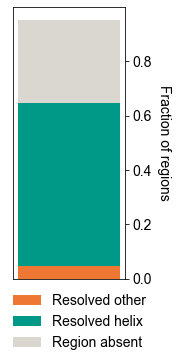

In [123]:
fig, ax = plt.subplots(figsize=(2,5))
ax.bar(" ",region_label_freqs["Resolved other"], label = "Resolved other", color=cscheme["sheet"])
ax.bar(" ",region_label_freqs["Resolved helix"], bottom=region_label_freqs["Resolved other"],
        label = "Resolved helix", color=cscheme["helix"])
ax.bar(" ",region_label_freqs["Region absent"], bottom=region_label_freqs["Resolved helix"],
        label = "Region absent", color="#D9D7CF")
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.legend(bbox_to_anchor=(1.3, -0.01), frameon=False)
plt.ylabel("Fraction of regions", rotation=270, labelpad=20)
plt.tick_params(bottom=False)
plt.show()

## E

In [15]:
# Calculate normalized hydropathy, net charge, and percent disordered for each sequence
hits_norm_hydrop = []
hits_norm_nc = []
hits_disordered = []

for index, row in df.iterrows():
    orf = row['orf']
    uid = row['uni_id']
    seq = row['region.seq']
    
    # Read alphafold pLDDT scoress for the sequence
    af_fp = paf.get_alphafold_fp(uid, path_to_af_data)+'.gz'
    try:
        pLDDTs = paf.read_bfactor_from_pdb(af_fp)[row['left.bound']:row['right.bound']]
    except FileNotFoundError:
        print(af_fp)
        continue
    
    # Calculate region hydropathy according to the normalized kyte-doolittle scale
    #hits_norm_hydrop.append(paf.calculate_hydropathy(seq, scale="kd"))
    hits_norm_hydrop.append(comp.calculate_hydropathy(seq, scale="kd_norm"))
    
    # Calculate normalized net charge
    nc = np.abs((seq.count('R') + seq.count('K') - seq.count('E') + seq.count('D'))) / row['region.len']
    hits_norm_nc.append(nc)
    
    # Read secondary structure
    structure = md.load(af_fp)
    ss = md.compute_dssp(structure, simplified=True)[0][row['left.bound']:row['right.bound']]
    
    # Score each residue as disordered or ordered based on pLDDT value
    #disordered = np.sum([1 for i in pLDDTs if i < 70.])
    disordered = 0
    for r, resid in enumerate(pLDDTs):
        if resid < 70.:
            disordered += 1
        elif ss[r] == 'C':
            disordered += 1
        
    # Calculate fraction disorder for the region
    hits_disordered.append(disordered / row['region.len'])
    

/Users/triandafillou/opt/anaconda3/lib/python3.8/site-packages/mdtraj/formats/pdb/pdbfile.py:196: UserWarning: Unlikely unit cell vectors detected in PDB file likely resulting from a dummy CRYST1 record. Discarding unit cell vectors.
  warnings.warn('Unlikely unit cell vectors detected in PDB file likely '


/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P53288-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P38811-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-P36022-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12019-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q6B0X1-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q08428-F1-model_v1.pdb.gz
/Volumes/DATA/alphafold/UP000002311_559292_YEAST/AF-Q12444-F1-model_v1.pdb.gz


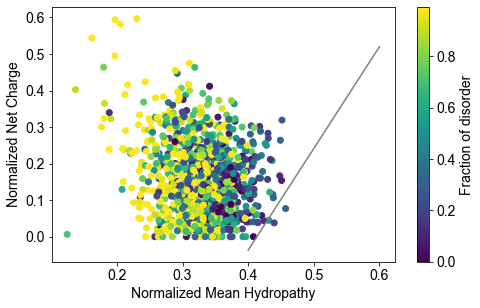

In [16]:
# Values for this diving line from the original paper by Uversky:
# Uversky, V. N., Gillespie, J. R., & Fink, A. L. (2000). Why are “natively unfolded” proteins unstructured under physiologic conditions? Proteins: Structure, Function and Genetics, 41(3), 415–427.
# https://doi.org/10.1002/1097-0134(20001115)41:3<415::AID-PROT130>3.0.CO;2-7
x = np.linspace(0.4,0.6,100)
y = 2.785*x - 1.151

fig,ax = plt.subplots(figsize=(7,4.5))
sc = ax.scatter(hits_norm_hydrop, hits_norm_nc,c=hits_disordered)
ax.plot(x, y, color = 'grey')
cbar = plt.colorbar(sc)
cbar.set_label('Fraction of disorder')
ax.set_xlabel('Normalized Mean Hydropathy')
ax.set_ylabel('Normalized Net Charge')
plt.tight_layout()
plt.show()